<a href="https://colab.research.google.com/github/YanaSemenenya/INTERPRETATOR/blob/develop/Examples/Economic_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk Prediction
**Xin Zhao**
<br>
This is a case study on Home Credit Default Risk Prediction using data from Home Credit Group and various machine learning algorithms. Techniques on feature selection and principal component analysis are also considered. In the end, XGBoost algorithm is selected. The prediction AUC score is 0.75. 

### Загрузка данных

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"falconwatch","key":"852b6d7f11534bcc686e2d63c56e894e"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'home-credit-default-risk'

 68% 25.0M/36.8M [00:00<00:00, 54.4MB/s]
100% 36.8M/36.8M [00:00<00:00, 82.1MB/s]
 95% 257M/271M [00:02<00:00, 89.7MB/s]
100% 271M/271M [00:02<00:00, 106MB/s] 
 84% 81.0M/96.7M [00:01<00:00, 90.3MB/s]
100% 96.7M/96.7M [00:01<00:00, 90.6MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 26.0MB/s]
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 134MB/s]
 83% 63.0M/76.3M [00:00<00:00, 76.5MB/s]
100% 76.3M/76.3M [00:00<00:00, 96.1MB/s]
 72% 26.0M/36.1M [00:00<00:00, 71.1MB/s]
100% 36.1M/36.1M [00:00<00:00, 102MB/s] 
 86% 5.00M/5.81M [00:00<00:00, 42.9MB/s]
100% 5.81M/5.81M [00:00<00:00, 37.1MB/s]
 87% 95.0M/109M [00:01<00:00, 86.9MB/s]
100% 109M/109M [00:01<00:00, 93.8MB/s] 
 72% 41.0M/56.8M [00:00<00:00, 68.9MB/s]
100% 56.8M/56.8M [00:00<00:00, 96.7MB/s]


In [4]:
! unzip application_train.csv.zip application_train.csv
! unzip application_test.csv.zip application_test.csv
! unzip bureau.csv.zip bureau.csv

Archive:  application_train.csv.zip
  inflating: application_train.csv   
Archive:  application_test.csv.zip
  inflating: application_test.csv    
Archive:  bureau.csv.zip
  inflating: bureau.csv              


### Импортируем библиотеки

In [5]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

In [6]:
from collections import defaultdict

# Explore and process bureau data

In [7]:
bureau = pd.read_csv('bureau.csv')

## Shape

In [8]:
bureau.shape

(1716428, 17)

## Categorical features in bureau

In [9]:
cat_features = bureau.select_dtypes(include='object').columns.tolist()
cat_features

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']


## Label encode the categorical features

In [10]:
bureau_transform = bureau.copy()

In [11]:
encoded_features = defaultdict(dict)
for col in cat_features:
    label_encoder = LabelEncoder()
    uniq_labels = bureau_transform[col].unique()
    bureau_transform[col] = label_encoder.fit_transform(bureau_transform[col])
    encoded_features[col] = dict(zip(uniq_labels,label_encoder.transform(uniq_labels)))

In [12]:
encoded_features

defaultdict(dict,
            {'CREDIT_ACTIVE': {'Active': 0,
              'Bad debt': 1,
              'Closed': 2,
              'Sold': 3},
             'CREDIT_CURRENCY': {'currency 1': 0,
              'currency 2': 1,
              'currency 3': 2,
              'currency 4': 3},
             'CREDIT_TYPE': {'Another type of loan': 0,
              'Car loan': 1,
              'Cash loan (non-earmarked)': 2,
              'Consumer credit': 3,
              'Credit card': 4,
              'Interbank credit': 5,
              'Loan for business development': 6,
              'Loan for purchase of shares (margin lending)': 7,
              'Loan for the purchase of equipment': 8,
              'Loan for working capital replenishment': 9,
              'Microloan': 10,
              'Mobile operator loan': 11,
              'Mortgage': 12,
              'Real estate loan': 13,
              'Unknown type of loan': 14}})

In [13]:
#feature_encode = onehot_encoder.get_feature_names(cat_features)
#bureau_cat_encode.columns = feature_encode
#bureau_cat_encode

## Extract numerical features and combine into the encoded categorical data

In [14]:
#num_features = ['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT']
#bureau_num = bureau[num_features] 
#bureau_proc = pd.concat([bureau_num, bureau_cat_encode], axis=1)
#print(bureau_proc.shape)
#print(bureau_num.shape)
#print(bureau_cat_encode.shape)

## Group sum and mean bureau data by loan ID

In [15]:
bureau_proc_sum = bureau_transform.groupby(['SK_ID_CURR']).sum()
bureau_proc_mean = bureau_transform.groupby(['SK_ID_CURR']).mean()

### Rename columns

In [16]:
new_collist_sum = []
for col in bureau_proc_sum.columns:
    if col == 'SK_ID_CURR':
        continue
    new_collist_sum.append(col + ' SUMBYID')
colname_dict = dict(zip(bureau_proc_sum.columns, new_collist_sum))
bureau_proc_sum = bureau_proc_sum.rename(columns=colname_dict)

In [17]:
new_collist_mean = []
for col in bureau_proc_mean.columns:
    if col == 'SK_ID_CURR':
        continue
    new_collist_mean.append(col + ' MEANBYID')
colname_dict_mean = dict(zip(bureau_proc_mean.columns, new_collist_mean))
bureau_proc_mean = bureau_proc_mean.rename(columns=colname_dict_mean)

### MERGE mean and sum bureau data

In [18]:
bureau_proc_final = pd.merge(bureau_proc_sum, bureau_proc_mean, how='left', on='SK_ID_CURR')

In [19]:
bureau_proc_final.to_csv('bureau_proc_final.csv', index=True)

In [20]:
bureau_proc_final = pd.read_csv('bureau_proc_final.csv')

# Process application_train/test

In [21]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')

## Check if 'SK_ID_CURR' in the train data

In [22]:
'SK_ID_CURR' in application_train.columns

True

## Merge bureau_proc_final to application data

In [23]:
train_merged = pd.merge(application_train, bureau_proc_final, how='left', on='SK_ID_CURR')
test_merged = pd.merge(application_test, bureau_proc_final, how='left', on='SK_ID_CURR')
print(application_train.shape)
print(train_merged.shape)
print(application_test.shape)
print(test_merged.shape)

(307511, 122)
(307511, 154)
(48744, 121)
(48744, 153)


## Drop ID columns for training

In [24]:
train_merged.drop('SK_ID_CURR', axis=1, inplace=True)
test_merged.drop('SK_ID_CURR', axis=1, inplace=True)

### DROP SOME FEATURES

In [25]:
features_to_drop = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE']
for feature in train_merged.columns:
    if 'FLAG_DOCUMENT' in feature:
        features_to_drop.append(feature)
train_merged.drop(features_to_drop, axis = 1, inplace = True)
test_merged.drop(features_to_drop, axis = 1, inplace = True)

### ADD NEW FEATURES

In [26]:
train_merged['PRICE/CREDIT'] = train_merged['AMT_GOODS_PRICE']/train_merged['AMT_CREDIT']
test_merged['PRICE/CREDIT'] = test_merged['AMT_GOODS_PRICE']/test_merged['AMT_CREDIT']

## Extract numerical and categorical features for further processing: impute, scaling

In [27]:
num_features_1 = train_merged.select_dtypes(include='int64').columns.tolist()
num_features_1.remove('TARGET')

In [28]:
num_features_2 = train_merged.select_dtypes(include='float64').columns.tolist()

In [29]:
cat_features = train_merged.select_dtypes(include='object').columns.tolist()

In [30]:
num_features = num_features_1 + num_features_2
features = num_features + cat_features

### EDA

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

 ### Обработка данных


Заполняем пропущенные значеня в вещественных фичах

In [34]:
for feature in num_features:
    fill_value = train_merged[feature].mean()
    train_merged[feature].fillna(fill_value, inplace = True)
    test_merged[feature].fillna(fill_value, inplace = True)

In [35]:
np.sum(train_merged[num_features].isna().sum() != 0)

0

Заполняем пропущенные значения в категориальных фичах и делаем лейбл энкодинг

In [36]:
for feature in cat_features:
    train_merged[feature].fillna('missing', inplace = True)
    test_merged[feature].fillna('missing', inplace = True)
    label_encoder = LabelEncoder()
    uniq_labels = train_merged[feature].unique()
    train_merged[feature] = label_encoder.fit_transform(train_merged[feature])

    encoded_features[feature] = dict(zip(uniq_labels,label_encoder.transform(uniq_labels)))
    test_merged[feature] = label_encoder.transform(test_merged[feature])

In [37]:
train_merged[cat_features].isna().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
FONDKAPREMONT_MODE            0
HOUSETYPE_MODE                0
WALLSMATERIAL_MODE            0
EMERGENCYSTATE_MODE           0
dtype: int64

### Сохраняем данные и делим выделяем таргер

In [38]:
#train_merged['AGE/EXPERIENCE'] = train_merged['DAYS_BIRTH']/train_merged['DAYS_EMPLOYED']
#test_merged['AGE/EXPERIENCE'] = test_merged['DAYS_BIRTH']/test_merged['DAYS_EMPLOYED']

In [39]:
train_merged.to_csv('train_merged.csv', index= False)
test_merged.to_csv('test_merged.csv', index = False)


In [40]:
X_train = train_merged.drop(['TARGET'], axis = 1)
X_test = test_merged.copy()
y_train = train_merged.TARGET.values
print('X_train shape:', X_train.shape)

X_train shape: (307511, 128)


### TRAINING LGBM Model

In [41]:
from lightgbm import LGBMClassifier

In [44]:
lgbm_model = LGBMClassifier(random_state=42, eval_metric="auc", 
                              max_depth=4,learning_rate=0.277, gamma=0.382)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', gamma=0.382, importance_type='split',
               learning_rate=0.277, max_depth=4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [50]:
import sklearn.metrics as metrics
def plot_AUC(model,X_test,y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc*2-1

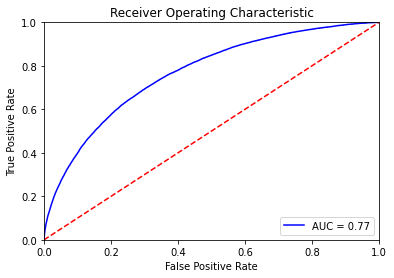

0.5341854955924572

In [51]:
plot_AUC(lgbm_model, X_train, y_train)

# Train logreg

In [52]:
from sklearn.linear_model import LogisticRegression

In [63]:
feature_imp = sorted([(f,i) for f,i in zip(X_train.columns, lgbm_model.feature_importances_)], key = lambda x: x[1], reverse=True)

In [70]:
selected_features = [f[0] for f in feature_imp[:20]]

In [73]:
logreg_model = LogisticRegression(random_state=42, max_iter=10000)
logreg_model.fit(X_train[selected_features], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

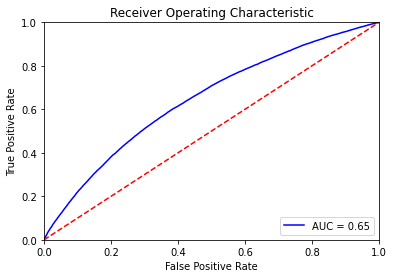

0.2904385293319054

In [74]:
plot_AUC(logreg_model, X_train[selected_features], y_train)

# Оценка экономического эффекта

In [82]:
data_analysis = X_train.copy()

logreg_predictions = [p[1] for p in logreg_model.predict_proba(X_train[selected_features])]
lgbm_predictions = [p[1] for p in lgbm_model.predict_proba(X_train)]

data_analysis['logreg_pd'] = logreg_predictions
data_analysis['lgbm_pd'] = lgbm_predictions
data_analysis['target'] = y_train

## Оценка по RWA

In [103]:
from scipy.stats import norm
import math

def get_rwa(my_pd, my_lgd, my_ead, my_r=0.03):
    k = (norm.cdf((norm.ppf(my_pd) + np.sqrt(my_r) * norm.ppf(0.999))/(np.sqrt(1-my_r))) - my_pd) * my_lgd
    rwa = k * 12.5 * my_ead
    return rwa

def eval_model(dataset, pd_column = 'pd_ttc', default_column = 'default_12m', ead_column = 'balance_at_report_dt'):
    g = roc_auc_score(dataset[default_column], dataset[pd_column])*2-1
    rwa_arr = get_rwa(dataset[pd_column], 0.72, dataset[ead_column])
    #rwa_ead_arr = rwa_arr / dataset[ead_column]
    rwa = rwa_arr.sum()/dataset[ead_column].sum()
    return g, rwa

def model_enchancment_profit(eads, rwa_base, rwa_adv):
  return np.sum(eads) * (rwa_base - rwa_adv)

In [106]:
print("Базовая модель, логрег")
base_model = eval_model(data_analysis, pd_column='logreg_pd', default_column='target', ead_column='AMT_CREDIT')
print('Gini: ', base_model[0])
print('RWA на рубль: ', base_model[1])
print('-------------------------------')

print("Продвинутая модель, LGBM")
advanced_model = eval_model(data_analysis, pd_column='lgbm_pd', default_column='target', ead_column='AMT_CREDIT')
print('Gini: ', advanced_model[0])
print('RWA на рубль: ', advanced_model[1])
print('-------------------------------')

print("Экономический эффект от улучшения модели")
model_enchancment_profit(data_analysis['AMT_CREDIT'], base_model[1], advanced_model[1])  

Базовая модель, логрег
Gini:  0.2904385293319054
RWA на рубль:  0.8948159199286473
-------------------------------
Продвинутая модель, LGBM
Gini:  0.5341854955924572
RWA:  0.8327243152449018
-------------------------------
Экономический эффект от улучшения модели


11437713451.812414

## Оценка по доходности

In [107]:
def get_profit(pds, defaults, margins, eads, lgds = 0.72, th=0.04):
    predicted_class = (pds>th).astype(int)
    tn, fp, fn, tp = confusion_matrix(defaults, predicted_class).ravel()
    profit = np.sum(tn*margins - fp*margins - fn*eads*lgds)/np.sum(eads)
    return profit

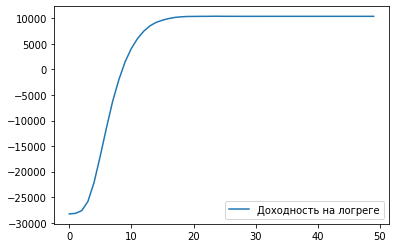

In [126]:

profits_logreg = list()
for t in range(50):
  th = t/100
  profit = get_profit(pds = data_analysis['logreg_pd'], 
              defaults = data_analysis['target'], 
              margins = data_analysis['AMT_CREDIT']*0.1, 
              eads = data_analysis['AMT_CREDIT'],
              th=th)
  profits_logreg.append(profit)

plt.plot(profits_logreg, label="Доходность на логреге")
plt.legend()

Text(0.5, 1.0, 'Доходность на LGBM')

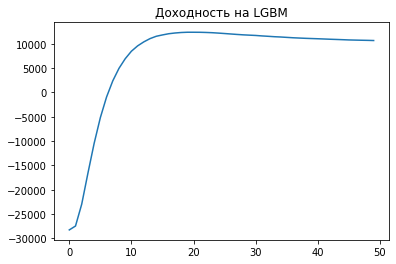

In [144]:
profits_lgbm = list()
for t in range(50):
  th = t/100
  profit = get_profit(pds = data_analysis['lgbm_pd'], 
              defaults = data_analysis['target'], 
              margins = data_analysis['AMT_CREDIT']*0.1, 
              eads = data_analysis['AMT_CREDIT'],
              th=th)
  profits_lgbm.append(profit)

plt.plot(profits_lgbm)
plt.title("Доходность на LGBM")

Text(0.5, 1.0, 'Насколько доходность LGBM выше логрега')

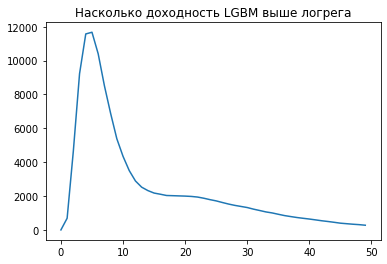

In [145]:
profits_diff = [lgbm - logreg for lgbm, logreg in zip(profits_lgbm, profits_logreg)]
plt.plot(profits_diff)
plt.title('Насколько доходность LGBM выше логрега')

Text(0.5, 1.0, 'Доход от потока LGBM против логрега')

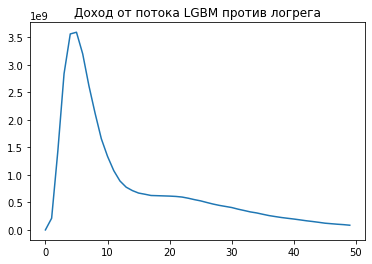

In [146]:
cnt = data_analysis.shape[0]
profits = [d * cnt for d in profits_diff]

plt.plot(profits)
plt.title("Доход от потока LGBM против логрега")